In [1]:
data = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"
!wget $data -O data-week-3.csv

--2025-12-24 15:29:15--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘data-week-3.csv’

data-week-3.csv     100%[===================>] 954.59K  --.-KB/s    in 0.05s   

2025-12-24 15:29:15 (18.1 MB/s) - ‘data-week-3.csv’ saved [977501/977501]



In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/teo/workspace/machine-learning-zoomcamp-homework/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.801277501774308)

# 2 Accuracy

Is 80% good or not?

In [9]:
len(y_val)

1409

In [10]:
(y_val == churn_decision).sum()

# accuracy = number of correct predictions / total number of predictions

np.int64(1129)

In [11]:
1129/1409

0.801277501774308

In [12]:
# But why did we use 0.5 as the threshold? Let's try a different threshold.

thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [13]:
accuracies = []
for t in thresholds:
    churn_decision = (y_pred >= t)
    accuracy = (y_val == churn_decision).mean()
    print(f'threshold: {t:.2f}, accuracy: {accuracy:.3f}')
    accuracies.append(accuracy)

threshold: 0.00, accuracy: 0.274
threshold: 0.05, accuracy: 0.509
threshold: 0.10, accuracy: 0.598
threshold: 0.15, accuracy: 0.664
threshold: 0.20, accuracy: 0.707
threshold: 0.25, accuracy: 0.737
threshold: 0.30, accuracy: 0.759
threshold: 0.35, accuracy: 0.766
threshold: 0.40, accuracy: 0.780
threshold: 0.45, accuracy: 0.793
threshold: 0.50, accuracy: 0.801
threshold: 0.55, accuracy: 0.798
threshold: 0.60, accuracy: 0.797
threshold: 0.65, accuracy: 0.784
threshold: 0.70, accuracy: 0.765
threshold: 0.75, accuracy: 0.744
threshold: 0.80, accuracy: 0.730
threshold: 0.85, accuracy: 0.726
threshold: 0.90, accuracy: 0.726
threshold: 0.95, accuracy: 0.726
threshold: 1.00, accuracy: 0.726


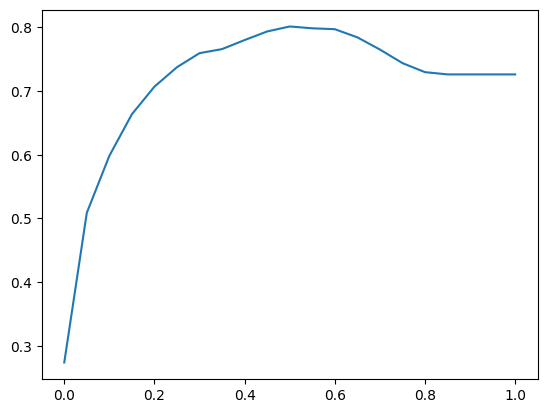

In [14]:
plt.plot(thresholds, accuracies)

In [15]:
# sklearn alredy has accuracy score functions

from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred >= 0.5)

0.801277501774308

Note that at a threshold 1.0, our accuracy is 73%, but all this means is that our model declares that no customer is ever going to churn.

In [16]:
from collections import Counter
Counter(y_pred >= 1.0)  # this is actually all the values because everything yields false

Counter({np.False_: 1409})

An accuracy of 73% (at threshold 1.0) still sounded quite good, and yet it's a useless model.

Because of this, accuracy doesn't really tell us how good our model is. Did we do all this work only to go from 73 to 80%? Doesn't seem like much.

In [17]:
Counter(y_val), y_val.mean()
# shows that in actuality 27% are churning and over 72% are not

(Counter({np.int64(0): 1023, np.int64(1): 386}),
 np.float64(0.2739531582682754))

This is called a class imbalance: we have more customers that are non-churning than churning ones (3:1), and in cases like this, we get an apparent good accuracy "for free" by just saying no one will churn (i.e. like the majority).

When there is a class imbalance, accuracy scores are misleading.

# 3 Confusion table

In [18]:
# we're looking for ways to evaluate our model that aren't sentive to class imbalance

# consider the outcome of our predictions vs. the actual values: we have four possibilities
# true positive (TP): we predicted churn and the customer actually churned
# true negative (TN): we predicted no churn and the customer actually didn't churn
# false positive (FP): we predicted churn but the customer actually didn't churn
# false negative (FN): we predicted no churn but the customer actually churned

# all our data points can be classified into one of these four categories

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predicted_positive = (y_pred >= t)
predicted_negative = (y_pred < t)

# these four are all arrays, like:
actual_positive[:10], predicted_positive[:10]

(array([False, False, False,  True, False, False, False, False,  True,
         True]),
 array([False, False, False,  True, False, False, False, False,  True,
        False]))

In [19]:
# and they can be combined with binary operations
tp = (predicted_positive & actual_positive).sum()
tp   # true positives - predicted and actual match

np.int64(214)

In [20]:
tn = (predicted_negative & actual_negative).sum()
tn   # true negatives - predicted and actual match

np.int64(915)

In [21]:
fp = (predicted_positive & actual_negative).sum()
fp   # false positives - predicted positive but actually negative

np.int64(108)

In [22]:
fn = (predicted_negative & actual_positive).sum()
fn   # false negatives - predicted negative but actually positive

np.int64(172)

In [23]:
# the confusion table is how we summarize these four numbers
confusion_matrix = np.array([[tn, fp],
                             [fn, tp]])
confusion_matrix

array([[915, 108],
       [172, 214]])

In [24]:
confusion_matrix.sum()

np.int64(1409)

In [25]:
# we can also normalize it to show proportions instead of counts
confusion_matrix / confusion_matrix.sum()

array([[0.64939674, 0.07665011],
       [0.12207239, 0.15188077]])

# 4 Precision and Recall

In [26]:
# precision = how many positive predictions were actually correct?
precision = tp / (tp + fp)
precision

# we aren't looking at those that we predicted negative (no churn)

np.float64(0.6645962732919255)

In [27]:
tp

np.int64(214)

In [28]:
tp+fp # 322 people are getting an offer to prevent churn,
# but only 214 of those would have churned

np.int64(322)

In [29]:
# recall = how many actual positives did we predict correctly
# out of all people who were actually positive?
recall = tp / (tp + fn)
recall

np.float64(0.5544041450777202)

In [30]:
tp+fn # 386 people are actual churners, but only 214 of them were predicted correctly 

np.int64(386)

So our model is not very good.

Precision is 66%, so there are 34% who are getting an offer and shouldn't - we're losing money.

Recall is 55%, so 45% of the actual churners we've failed to identify.

# 5 ROC Curves
Receiver Operating Characteristics

We consider FPR = False Positive Rate and TPR = True Positive Rate

FPR = FP/(TN+FP) = fraction of false positives among all negatives

TPR = TP/(FN+TP) = fraction of true positives among all positives

FPR needs to be minimized, TPR needs to be as large as possible.

In [31]:
tpr = tp/(tp + fn) # it's actually the same as recall
tpr

np.float64(0.5544041450777202)

In [32]:
fpr = fp/(fp + tn)
fpr

np.float64(0.10557184750733138)

In [33]:
# The ROC curve (receiver operating characteristic curve) is a plot of TPR vs
# FPR at different thresholds

thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predicted_positive = (y_pred >= t)
    predicted_negative = (y_pred < t)
    
    tp = (predicted_positive & actual_positive).sum()
    tn = (predicted_negative & actual_negative).sum()
    fp = (predicted_positive & actual_negative).sum()
    fn = (predicted_negative & actual_positive).sum()
        
    scores.append((t, tp, fp, fn, tn))

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10] # show every 10th row


,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,367,547,19,476
20,0.2,334,361,52,662
30,0.3,291,244,95,779
40,0.4,253,177,133,846
50,0.5,214,108,172,915
60,0.6,153,53,233,970
70,0.7,69,14,317,1009
80,0.8,5,0,381,1023
90,0.9,0,0,386,1023


In [34]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,367,547,19,476,0.950777,0.534702
20,0.2,334,361,52,662,0.865285,0.352884
30,0.3,291,244,95,779,0.753886,0.238514
40,0.4,253,177,133,846,0.655440,0.173021
50,0.5,214,108,172,915,0.554404,0.105572
60,0.6,153,53,233,970,0.396373,0.051808
70,0.7,69,14,317,1009,0.178756,0.013685
80,0.8,5,0,381,1023,0.012953,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


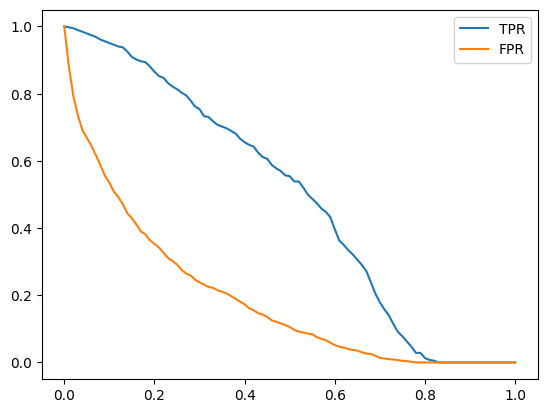

In [35]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()

Reminder: we want FPR to go down as fast as possible, and TRP as little as possible

Let's compare our model to a random model...

### Random model

In [36]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand[:10]

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, 3.02332573e-01,
       1.46755891e-01, 9.23385948e-02, 1.86260211e-01, 3.45560727e-01,
       3.96767474e-01, 5.38816734e-01])

In [37]:
# we expect accuracy to be quite low, it's just a coin flip...
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

Now we want to plot our model with this random model.

In [38]:
# let's put the calculations from before into a function

def tpr_fpr_dataframe(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)

    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predicted_positive = (y_pred >= t)
        predicted_negative = (y_pred < t)
        
        tp = (predicted_positive & actual_positive).sum()
        tn = (predicted_negative & actual_negative).sum()
        fp = (predicted_positive & actual_negative).sum()
        fn = (predicted_negative & actual_positive).sum()
            
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [39]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


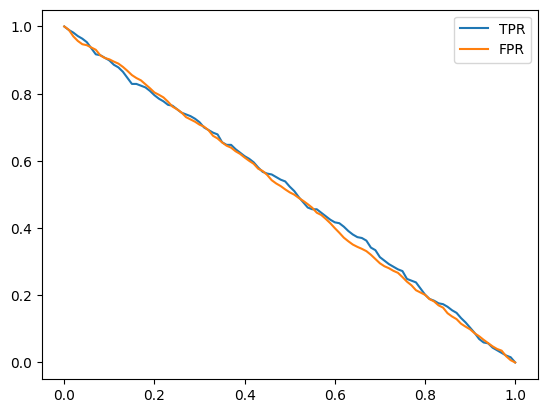

In [40]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')

plt.legend()

So clearly this is what a random coin flip looks like, in comparison to our logistic regression model.

How would an ideal model behave?

### Ideal model

In [41]:
# the ideal model orders the customers by score perfectly, everyone before the threshold
# is a non churn, everyone after the threshold is churn

num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [42]:
y_ideal = np.repeat([0, 1], repeats=[num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [43]:
y_ideal_pred = np.linspace(0, 1, len(y_val)) # clearly we are faking a perfect model
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00], shape=(1409,))

In [44]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [45]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

This model doesn't exist in reality, it's a fake we filled out as a benchmark.

In [46]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


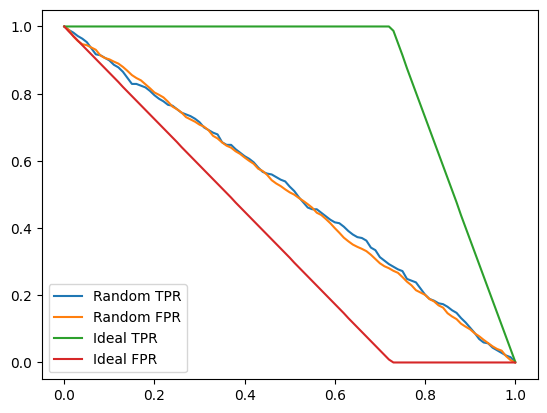

In [47]:
plt.plot(df_rand.threshold, df_rand.tpr, label='Random TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='Random FPR')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='Ideal TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='Ideal FPR')
plt.legend()

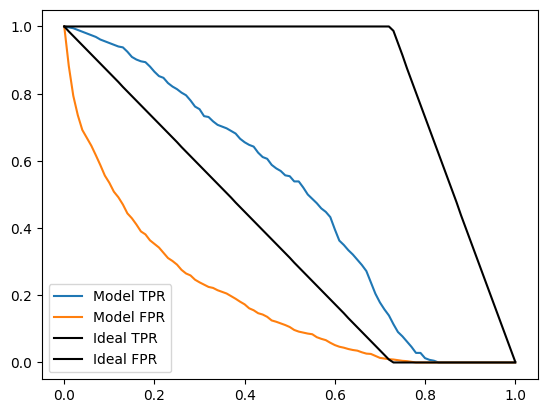

In [48]:
# let's put it all together
plt.plot(df_scores.threshold, df_scores.tpr, label='Model TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='Model FPR')

plt.plot(df_ideal.threshold, df_ideal.tpr, label='Ideal TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='Ideal FPR', color='black')
plt.legend()


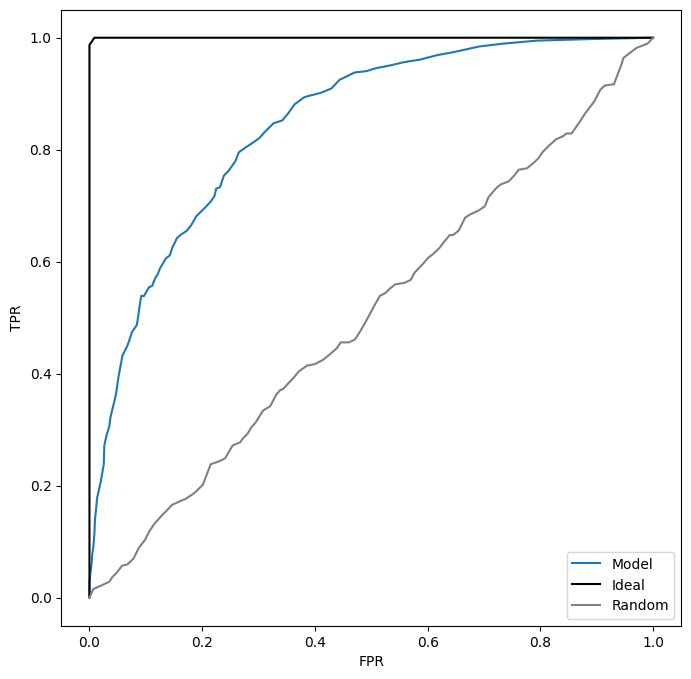

In [49]:
# let's plot TPR vs FPR for both models

plt.figure(figsize=(8, 8)) # just to make it square

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal', color='black')
plt.plot(df_rand.fpr, df_rand.tpr, label='Random', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

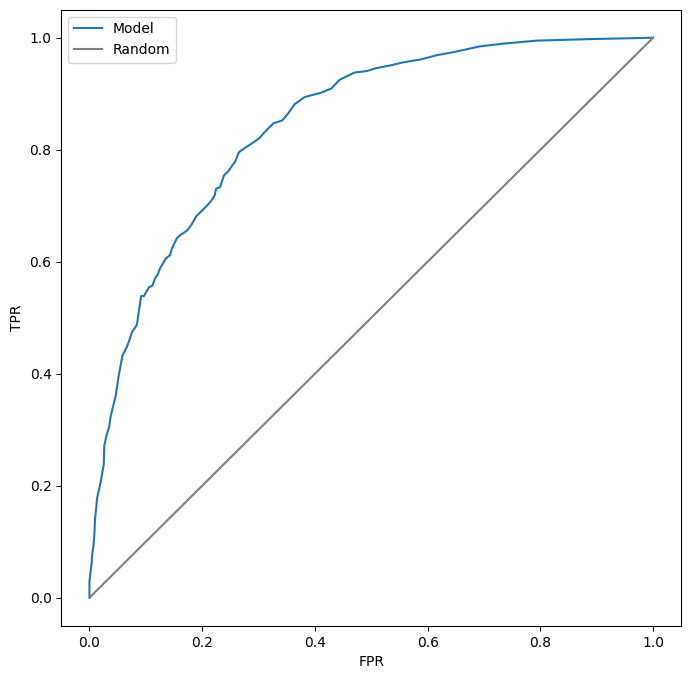

In [50]:
# just to clean it up:

# let's plot TPR vs FPR for both models

plt.figure(figsize=(8, 8)) # just to make it square

plt.plot(df_scores.fpr, df_scores.tpr, label='Model') # this is the ROC curve

plt.plot([0,1], [0,1], label='Random', color='gray') # random model
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

## Plotting ROC Curves With Scikit-Learn

Reminder: ROC = Receiver Operating Characteristics

In [51]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

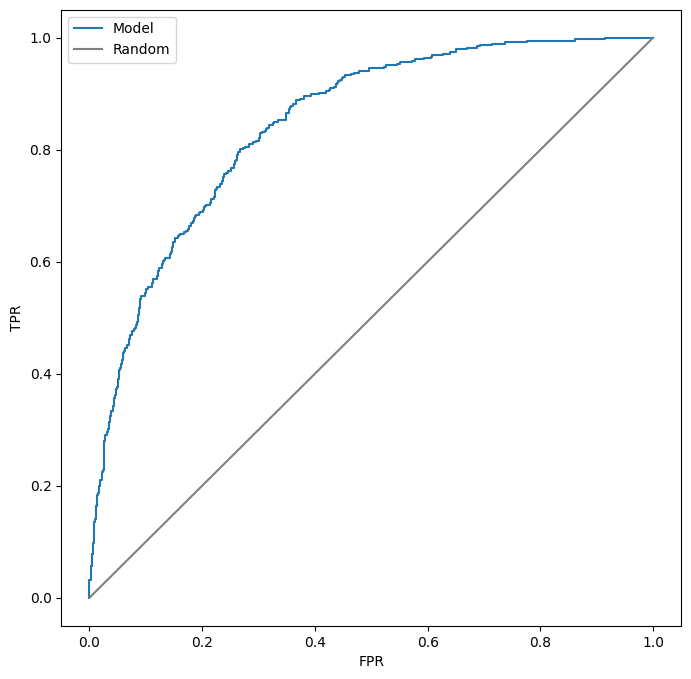

In [52]:
# let's plot the fpr, tpr, thresholds provided by sklearn
# it's more accurate than our own linspace

plt.figure(figsize=(8, 8)) # just to make it square

plt.plot(fpr, tpr, label='Model') # this is the ROC curve

plt.plot([0,1], [0,1], label='Random', color='gray') # random model
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# 6 ROC AUC
Reminder: ROC = Receiver Operating Characteristics

ROC AUC = Area under ROC curve

A single number that measures roughly how close we are to the ideal model (maximum TPR, minimum FPR)

For the random model, ROC AUC = 0.5

For the ideal model, ROC AUC = 1.0

In [53]:
from sklearn.metrics import auc # this is for any curve, not specifically ROC
auc(fpr, tpr)

0.8445038720820102

In [54]:
auc(df_scores.fpr, df_scores.tpr) # our calculation almost perfectly matches sklearn's

0.8443696534119398

In [55]:
auc(df_ideal.fpr, df_ideal.tpr), auc(df_rand.fpr, df_rand.tpr)

(0.9999430203759136, 0.5060233793728696)

In [56]:
from sklearn.metrics import roc_auc_score # ROC-specific AUC, takes val/pred arrays directly
roc_auc_score(y_val, y_pred)

0.8445038720820102

Interpretation: AUC tells us the probability that a randomly selected positive example has a higher score than a randomly selected negative example.

In [57]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [58]:
import random

n = 10000
success = 0

for i in range(n):
    random_positive_index = random.randint(0, len(pos) - 1)
    random_negative_index = random.randint(0, len(neg) - 1)
    if pos[random_positive_index] > neg[random_negative_index]:
        success += 1
success / n

0.8463

In [59]:
# It's pretty close to roc_auc_score

# We can do the same thing with numpy in a vectorized way
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)
pos_ind, neg_ind

(array([261, 200,   9, ..., 210, 232, 186], shape=(10000,)),
 array([246, 705, 964, ..., 996, 121, 332], shape=(10000,)))

In [60]:
(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.8372)

Woah!

# 7 Cross-Validation

We will deal with parameter tuning...

Usually when we split, we first set aside the test dataset, that's fine... but concerning the validation dataset, we don't necessarily need to chop it off. We can instead do k-fold cross-validation.

Example: after putting away the test dataset, we split what we have into 3 chunks called folds.
* We train on 1+2 and validate against 3.
* We train on 1+3 and validate against 2.
* We train on 2+3 and validate against 1.

We get 3 numbers AUC1, AUC2, AUC3, and we joing them into a mean AUC+stdev. The stdev shows how much the scores differ across different folds, i.e. how stable our model is.

In [61]:
def train(df, y_train, C=1.0): #with regularization
    dicts = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)

    return dv, model

In [62]:
dv, model = train(df_train, y_train)

In [63]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [64]:
y_pred = predict(df_val, dv, model)

In [65]:
# to track iterations
!pip install tqdm


In [66]:

# now we can do k-fold
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

kfold = KFold(n_splits=10, shuffle=True, random_state=1) # 10 folds

n_splits = 5

for C in tqdm([0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0]):

    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('%s %.4f ± %.4f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

0.0001 0.8110 ± 0.0119
0.001 0.8261 ± 0.0118
0.01 0.8408 ± 0.0118
0.1 0.8425 ± 0.0117
1.0 0.8425 ± 0.0116
5.0 0.8424 ± 0.0116
10.0 0.8424 ± 0.0116


In [67]:
# now that we've gone through k-fold, we can train on the full training set
# and evaluate on the test set

dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)
auc = roc_auc_score(y_test, y_pred)
auc

0.8584032088573997